In [1]:
# Install missing libraries
!pip install lightgbm catboost

import os
import glob
import zipfile
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm # Improved progress bar for Jupyter/Colab

# Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, ElasticNetCV, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor,
                              GradientBoostingRegressor, StackingRegressor)
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

# Boosting Libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Metrics
from scipy.stats import pearsonr, spearmanr, kendalltau

# Settings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.1 MB/s eta 0:00:00


In [2]:
# ---------------- 1. ZIP EXTRACTION ----------------
zip_filename = 'features.zip'
extract_path = '/content/features_data'

if os.path.exists(zip_filename):
    if not os.path.exists(extract_path):
        print(f"Unzipping {zip_filename}...")
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
    else:
        print("Files already extracted.")
else:
    print(f"WARNING: {zip_filename} not found. Please upload it to Colab.")

feature_root = os.path.abspath(extract_path)

# ---------------- 2. LOAD MOS FILES ----------------
uid_excel  = 'mos_UID.xlsx'
saud_excel = 'SAUD_MOS.xlsx'

X_list, y_list, dataset_id_list = [], [], []

# ---------------- 3. PROCESS UID DATASET ----------------
if os.path.exists(uid_excel):
    df_uid = pd.read_excel(uid_excel)
    uid_map = dict(zip(df_uid['Name'], df_uid['MOS']))

    all_files = glob.glob(os.path.join(feature_root, '**', '*.mat'), recursive=True)
    count_uid = 0

    for fpath in all_files:
        img_name = os.path.splitext(os.path.basename(fpath))[0] + ".png"
        if img_name in uid_map:
            try:
                mat = scipy.io.loadmat(fpath)
                if 'features' in mat:
                    feat = mat['features'].flatten()
                    if feat.shape[0] == 25:
                        X_list.append(feat)
                        y_list.append(uid_map[img_name])
                        dataset_id_list.append(0)  # ID 0 for UID
                        count_uid += 1
            except:
                pass
    print(f"UID Data Loaded: {count_uid} samples")

# ---------------- 4. PROCESS SAUD DATASET ----------------
if os.path.exists(saud_excel):
    df_saud = pd.read_excel(saud_excel)
    def clean_name(fname):
        return fname.strip("'").strip() if isinstance(fname, str) else fname

    df_saud['clean'] = df_saud['Name'].apply(clean_name)
    saud_map = dict(zip(df_saud['clean'], df_saud['MOS']))

    count_saud = 0
    # Reuse file list for efficiency
    for fpath in all_files:
        parts = fpath.replace('\\', '/').split('/')
        if len(parts) > 3:
            name = os.path.splitext(parts[-1])[0] + ".png"
            key = f"{parts[-3]}/{parts[-2]}/{name}"

            score = saud_map.get(key) or saud_map.get(name)
            if score is not None:
                try:
                    mat = scipy.io.loadmat(fpath)
                    if 'features' in mat:
                        feat = mat['features'].flatten()
                        if feat.shape[0] == 25:
                            X_list.append(feat)
                            y_list.append(score)
                            dataset_id_list.append(1)  # ID 1 for SAUD
                            count_saud += 1
                except:
                    pass
    print(f"SAUD Data Loaded: {count_saud} samples")

# ---------------- 5. FINALIZE ARRAYS ----------------
if len(X_list) > 0:
    X = np.array(X_list)
    y = np.array(y_list)
    ids = np.array(dataset_id_list).reshape(-1, 1)

    # Append Dataset ID as the 26th Feature
    X = np.hstack([X, ids])

    # Handle NaNs/Infs
    X = np.where(np.isinf(X), np.nan, X)
    if np.isnan(X).any():
        col_mean = np.nanmean(X, axis=0)
        inds = np.where(np.isnan(X))
        X[inds] = np.take(col_mean, inds[1])

    print(f"\nRAW DATA SHAPE: {X.shape}")
else:
    print("ERROR: No data loaded.")

Unzipping features.zip...
UID Data Loaded: 960 samples
SAUD Data Loaded: 1000 samples

RAW DATA SHAPE: (1960, 26)


In [3]:
def enhance_features(X_in):
    # 1. Log Transform: Handles heavy-tailed image stats
    # Use log1p(abs(x)) to be safe against zeros and negatives
    X_log = np.log1p(np.abs(X_in))

    # 2. Square Transform: Captures quadratic relationships
    X_sq = X_in ** 2

    # Combine: [Original, Log, Square]
    X_out = np.hstack([X_in, X_log, X_sq])

    # Sanity check for numbers
    X_out = np.where(np.isinf(X_out), 0, X_out)
    X_out = np.where(np.isnan(X_out), 0, X_out)

    return X_out

print("Enhancing features with Log and Square transforms...")
X_enhanced = enhance_features(X)
print(f"New Feature Count: {X_enhanced.shape[1]} (Original was {X.shape[1]})")

# Update X global variable
X = X_enhanced

Enhancing features with Log and Square transforms...
New Feature Count: 78 (Original was 26)


In [4]:
def run_simulation(model_class, param_grid, X, y, n_iters=20, scale=False, model_name="Model"):
    plcc_scores, srcc_scores, krcc_scores, rmse_scores = [], [], [], []

    # Progress Bar Description
    pbar = tqdm(range(n_iters), desc=f"Running {model_name}", leave=False)

    for i in pbar:
        # 1. Split Data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

        # 2. Scale (Only if needed)
        if scale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        # 3. Initialize & Fit
        if isinstance(model_class, type) or callable(model_class):
            if param_grid:
                # Basic Grid Search
                model = GridSearchCV(model_class(), param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
                model.fit(X_train, y_train)
                best_model = model.best_estimator_
            else:
                best_model = model_class()
                best_model.fit(X_train, y_train)
        else:
            # It's an already instantiated object (like StackingRegressor)
            best_model = model_class
            best_model.fit(X_train, y_train)

        # 4. Predict
        preds = best_model.predict(X_test)

        # 5. Metrics
        plcc = pearsonr(y_test, preds)[0]
        srcc = spearmanr(y_test, preds)[0]

        plcc_scores.append(plcc)
        srcc_scores.append(srcc)
        krcc_scores.append(kendalltau(y_test, preds)[0])
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))

        # Update progress bar with current PLCC/SRCC
        pbar.set_postfix({'SRCC': f"{srcc:.3f}", 'PLCC': f"{plcc:.3f}"})

    avg_metrics = [
        np.mean(plcc_scores),
        np.mean(srcc_scores),
        np.mean(krcc_scores),
        np.mean(rmse_scores)
    ]
    # Print final result after bar closes
    print(f"Finished {model_name} -> SRCC: {avg_metrics[1]:.4f} | PLCC: {avg_metrics[0]:.4f}")
    return avg_metrics

In [5]:
# Pipeline for SVR to handle scaling automatically
svr_pipeline = make_pipeline(
    StandardScaler(),
    SVR(C=100, epsilon=0.1, gamma='scale')
)

models_config = {
    "SVR (RBF)": {
        "class": lambda: svr_pipeline,
        "params": {},
        "scale": False # Pipeline handles it
    },
    "CatBoost": {
        "class": CatBoostRegressor,
        "params": {'iterations': [800], 'learning_rate': [0.02], 'depth': [6], 'verbose': [0], 'allow_writing_files': [False]},
        "scale": False
    },
    "XGBoost": {
        "class": xgb.XGBRegressor,
        "params": {'n_estimators': [500], 'learning_rate': [0.02], 'max_depth': [6], 'subsample': [0.7], 'n_jobs': [-1]},
        "scale": False
    },
    "LightGBM": {
        "class": lgb.LGBMRegressor,
        "params": {'n_estimators': [500], 'learning_rate': [0.05], 'num_leaves': [31], 'verbose': [-1]},
        "scale": False
    },
    "Random Forest": {
        "class": RandomForestRegressor,
        "params": {'n_estimators': [200]},
        "scale": False
    }
}

In [6]:
ITERATIONS = 20 # Number of random splits per model

all_results = []
model_names = []

print(f"--- Starting Standard Benchmark ({ITERATIONS} iters) ---\n")

for name, config in models_config.items():
    metrics = run_simulation(
        model_class=config["class"],
        param_grid=config["params"],
        X=X, y=y,
        n_iters=ITERATIONS,
        scale=config["scale"],
        model_name=name
    )
    all_results.append(metrics)
    model_names.append(name)

--- Starting Standard Benchmark (20 iters) ---



Running SVR (RBF):   0%|          | 0/20 [00:00<?, ?it/s]

Finished SVR (RBF) -> SRCC: 0.8818 | PLCC: 0.8798


Running CatBoost:   0%|          | 0/20 [00:00<?, ?it/s]

Finished CatBoost -> SRCC: 0.8986 | PLCC: 0.8990


Running XGBoost:   0%|          | 0/20 [00:00<?, ?it/s]

Finished XGBoost -> SRCC: 0.9032 | PLCC: 0.9005


Running LightGBM:   0%|          | 0/20 [00:00<?, ?it/s]

Finished LightGBM -> SRCC: 0.8967 | PLCC: 0.8920


Running Random Forest:   0%|          | 0/20 [00:00<?, ?it/s]

Finished Random Forest -> SRCC: 0.8961 | PLCC: 0.8937


In [7]:
print("\n--- Training Super-Stacking Ensemble ---")

# 1. Base Learners: A mix of Tree, Kernel, and Distance methods
estimators = [
    # Trees (Structure Experts)
    ('cat', CatBoostRegressor(iterations=1000, learning_rate=0.02, depth=6, verbose=0, allow_writing_files=False)),
    ('xgb', xgb.XGBRegressor(n_estimators=600, learning_rate=0.02, max_depth=6, subsample=0.7, n_jobs=-1)),

    # Kernel (Math Expert) - Scaled internally
    ('svr', make_pipeline(StandardScaler(), SVR(C=100, gamma='scale', epsilon=0.1))),

    # Distance (Similarity Expert) - Scaled internally
    # KNN helps fix outliers by looking at the 15 most similar images
    ('knn', make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=15, weights='distance', metric='manhattan')))
]

# 2. Meta Learner: ElasticNetCV
# Automatically tunes the mix of Ridge (L2) and Lasso (L1) regularization
final_estimator = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99],
    cv=5,
    max_iter=2000
)

# 3. Build Stack
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    n_jobs=-1,
    passthrough=False
)

# 4. Run Simulation
stack_metrics = run_simulation(
    model_class=stacking_model,
    param_grid={},
    X=X, y=y,
    n_iters=ITERATIONS,
    scale=False, # Base models have pipelines
    model_name="Super-Stack (KNN+Trees)"
)

all_results.append(stack_metrics)
model_names.append("Super-Stack (KNN+Trees)")


--- Training Super-Stacking Ensemble ---


Running Super-Stack (KNN+Trees):   0%|          | 0/20 [00:00<?, ?it/s]

Finished Super-Stack (KNN+Trees) -> SRCC: 0.9098 | PLCC: 0.9048



FINAL LEADERBOARD
                           PLCC    SRCC    KRCC    RMSE
Super-Stack (KNN+Trees)  0.9048  0.9098  0.7354  1.2176
XGBoost                  0.9005  0.9032  0.7270  1.2462
CatBoost                 0.8990  0.8986  0.7216  1.2713
Random Forest            0.8937  0.8961  0.7179  1.2930
LightGBM                 0.8920  0.8967  0.7164  1.2931
SVR (RBF)                0.8798  0.8818  0.6990  1.3717


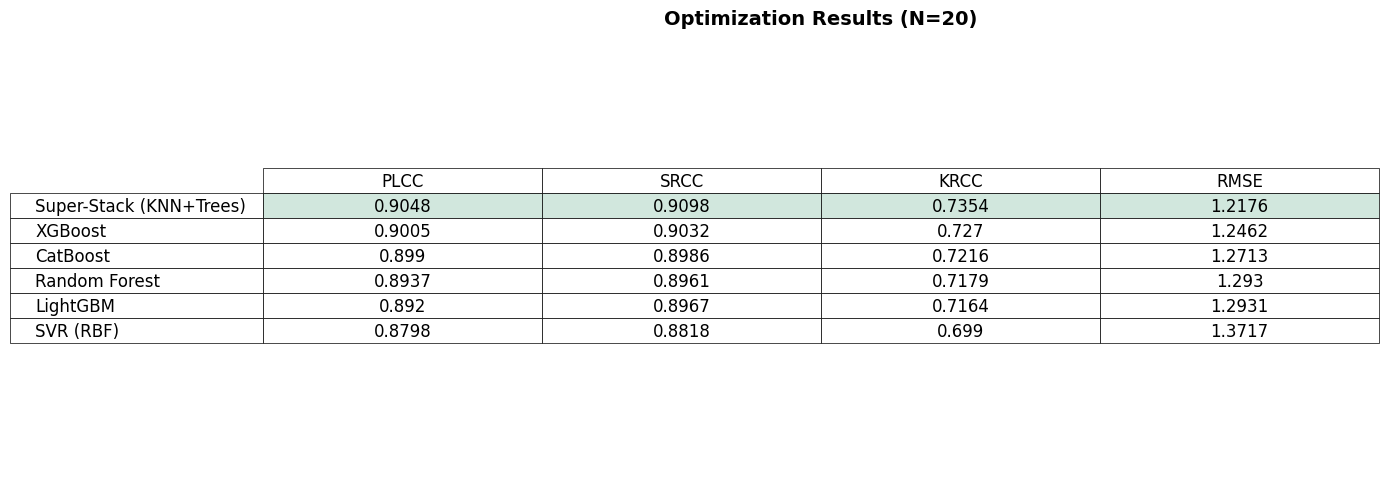

In [8]:
# Create DataFrame
df = pd.DataFrame(all_results, columns=['PLCC', 'SRCC', 'KRCC', 'RMSE'], index=model_names)

df = df.sort_values(by='PLCC', ascending=False)

# Print
print("\n" + "="*50)
print("FINAL LEADERBOARD")
print("="*50)
print(df.round(4))

# Plot Table
fig, ax = plt.subplots(figsize=(12, len(df)*0.8 + 1))
ax.axis('tight')
ax.axis('off')

# Color the "Stacking" row if it exists to highlight it
cell_colours = [['#ffffff']*4 for _ in range(len(df))]
for i, name in enumerate(df.index):
    if "Stack" in name:
        cell_colours[i] = ['#d1e7dd']*4 # Light Green for the winner

table = ax.table(cellText=df.round(4).values,
                 colLabels=df.columns,
                 rowLabels=df.index,
                 cellColours=cell_colours,
                 cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title(f"Optimization Results (N={ITERATIONS})", weight='bold', fontsize=14)
plt.show()